<a href="https://colab.research.google.com/github/intel-analytics/analytics-zoo/blob/master/python/orca/colab-notebook/quickstart/ncf_xshards_pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


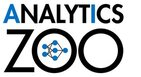
---

## **Environment Preparation**

**Install Java 8**

Run the cell on the **Google Colab** to install jdk 1.8.

**Note:** if you run this notebook on your computer, root permission is required when running the cell to install Java 8. (You may ignore this cell if Java 8 has already been set up in your computer).

In [ ]:
# Install jdk8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
# Set environment variable JAVA_HOME.
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version

**Install Analytics Zoo**

You can install the latest release version or latest pre-release version using `pip install --pre --upgrade bigdl-orca`. 

In [ ]:
# Install latest release version of analytics-zoo 
# Installing analytics-zoo from pip will automatically install pyspark, bigdl, and their dependencies.
!pip install --pre --upgrade bigdl-orca

In [ ]:
# Install python dependencies
!pip install tensorflow==1.15.0

## **Data-Parallel Pandas with XShards for Distributed Deep Learning** 

In this guide we will describe how to use `XShards` in Orca to process large-scale dataset using existing Pyhton codes in a distributed and data-parallel fashion.

#### **Intialization** 

import necessary libraries

In [ ]:
import os
import zipfile
import argparse

import numpy as np
import tensorflow as tf

from bigdl.dllib.feature.dataset import base
from sklearn.model_selection import train_test_split

from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca import OrcaContext
from bigdl.orca.learn.tf.estimator import Estimator
from bigdl.orca.data import SharedValue
import bigdl.orca.data.pandas

### **Init Orca Context** 

In [ ]:
# recommended to set it to True when running Analytics Zoo in Jupyter notebook 
OrcaContext.log_output = True # (this will display terminal's stdout and stderr in the Jupyter notebook).

cluster_mode = "local"

if cluster_mode == "local":  
    init_orca_context(cluster_mode="local", cores=4) # run in local mode
elif cluster_mode == "yarn":  
    init_orca_context(cluster_mode="yarn-client", num_nodes=2, cores=2, driver_memory="6g") # run on Hadoop YARN cluster

### **Data Preprocessing with XShards**

An XShards contains an automatically sharded (or partitioned) Python object (e.g., Pandas Dataframe, Numpy NDArray, Python Dictionary or List, etc.). Each partition of the XShards stores a subset of the Python object and is distributed across different nodes in the cluster; and the user may run arbitrary Python codes on each partition in a data-parallel fashion using `XShards.transform_shard`.

In [6]:
# Download and extract movielens 1M data.
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
local_file = base.maybe_download('ml-1m.zip', '.', url)
if not os.path.exists('./ml-1m'):
        zip_ref = zipfile.ZipFile(local_file, 'r')
        zip_ref.extractall('.')
        zip_ref.close()

In [7]:
# Read in the dataset, and do a little preprocessing
rating_files="./ml-1m/ratings.dat"
new_rating_files="./ml-1m/ratings_new.dat"
if not os.path.exists(new_rating_files):
        fin = open(rating_files, "rt")
        fout = open(new_rating_files, "wt")
        for line in fin:
            # replace :: to : for spark 2.4 support
            fout.write(line.replace('::', ':'))
        fin.close()
        fout.close()

Read movive len csv to XShards of Pandas Dataframe.

In [ ]:
full_data = bigdl.orca.data.pandas.read_csv(new_rating_files, sep=':', header=None,
                                          names=['user', 'item', 'label'], usecols=[0, 1, 2],
                                          dtype={0: np.int32, 1: np.int32, 2: np.int32})
user_set = set(full_data['user'].unique())
item_set = set(full_data['item'].unique())

min_user_id = min(user_set)
max_user_id = max(user_set)
min_item_id = min(item_set)
max_item_id = max(item_set)
print(min_user_id, max_user_id, min_item_id, max_item_id)

Use `XShards` to process large-scale dataset with existing Pyhton codes in a distributed and data-parallel fashion. 
Run Python codes on each partition in a data-parallel fashion using `XShards.transform_shard`, as shown below. 

In [9]:
# update label starting from 0. That's because ratings go from 1 to 5, while the matrix columns go from 0 to 4
def update_label(df):
  df['label'] = df['label'] - 1
  return df

# run Python codes on each partition in a data-parallel fashion using `XShards.transform_shard`
full_data = full_data.transform_shard(update_label)

In [10]:
# split to train/test dataset
def split_train_test(data):
  train, test = train_test_split(data, test_size=0.2, random_state=100)
  return train, test

train_data, test_data = full_data.transform_shard(split_train_test).split()

### **Define NCF Model**

In [ ]:
class NCF(object):
    def __init__(self, embed_size, user_size, item_size):
        self.user = tf.placeholder(dtype=tf.int32, shape=(None,))
        self.item = tf.placeholder(dtype=tf.int32, shape=(None,))
        self.label = tf.placeholder(dtype=tf.int32, shape=(None,))
  
        # GMF part starts
        with tf.name_scope("GMF"):
            user_embed_GMF = tf.contrib.layers.embed_sequence(self.user, vocab_size=user_size + 1,
                                                              embed_dim=embed_size)
            item_embed_GMF = tf.contrib.layers.embed_sequence(self.item, vocab_size=item_size + 1,
                                                              embed_dim=embed_size)
            GMF = tf.multiply(user_embed_GMF, item_embed_GMF)

        # MLP part starts
        with tf.name_scope("MLP"):
            user_embed_MLP = tf.contrib.layers.embed_sequence(self.user, vocab_size=user_size + 1,
                                                              embed_dim=embed_size)
            item_embed_MLP = tf.contrib.layers.embed_sequence(self.item, vocab_size=item_size + 1,
                                                              embed_dim=embed_size)
            interaction = tf.concat([user_embed_MLP, item_embed_MLP], axis=-1)
            layer1_MLP = tf.layers.dense(inputs=interaction, units=embed_size * 2)
            layer1_MLP = tf.layers.dropout(layer1_MLP, rate=0.2)
            layer2_MLP = tf.layers.dense(inputs=layer1_MLP, units=embed_size)
            layer2_MLP = tf.layers.dropout(layer2_MLP, rate=0.2)
            layer3_MLP = tf.layers.dense(inputs=layer2_MLP, units=embed_size // 2)
            layer3_MLP = tf.layers.dropout(layer3_MLP, rate=0.2)

        # Concate the two parts together
        with tf.name_scope("concatenation"):
            concatenation = tf.concat([GMF, layer3_MLP], axis=-1)
            self.logits = tf.layers.dense(inputs=concatenation, units=5)
            self.logits_softmax = tf.nn.softmax(self.logits)
            self.class_number = tf.argmax(self.logits_softmax, 1)

        with tf.name_scope("loss"):
            self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=self.label, logits=self.logits, name='loss'))

        with tf.name_scope("optimzation"):
            self.optim = tf.train.AdamOptimizer(1e-3, name='Adam')
            self.optimizer = self.optim.minimize(self.loss)

embedding_size=16
model = NCF(embedding_size, max_user_id, max_item_id)

### **Fit with Orca Estimator**

In [ ]:
batch_size=1280
epochs=1
model_dir='./'

# create an Estimator.
estimator = Estimator.from_graph(
            inputs=[model.user, model.item],
            outputs=[model.class_number],
            labels=[model.label],
            loss=model.loss,
            optimizer=model.optim,
            model_dir=model_dir,
            metrics={"loss": model.loss})

# fit the Estimator
estimator.fit(data=train_data,
              batch_size=1280,
              epochs=1,
              feature_cols=['user', 'item'],
              label_cols=['label'],
              validation_data=test_data)

checkpoint_path = os.path.join(model_dir, "NCF.ckpt")
estimator.save_tf_checkpoint(checkpoint_path)
estimator.shutdown()

In [15]:
# predict using the Estimator
def predict(predict_data, user_size, item_size):

    tf.reset_default_graph()

    with tf.Session() as sess:
        model = NCF(embedding_size, user_size, item_size)

        saver = tf.train.Saver(tf.global_variables())
        checkpoint_path = os.path.join(model_dir, "NCF.ckpt")
        saver.restore(sess, checkpoint_path)

        estimator = Estimator.from_graph(
            inputs=[model.user, model.item],
            outputs=[model.class_number],
            sess=sess,
            model_dir=model_dir
        )
        predict_result = estimator.predict(predict_data, feature_cols=['user', 'item'])
        predictions = predict_result.collect()
        assert 'prediction' in predictions[0]
        print(predictions[0]['prediction'])

In [ ]:
predict(test_data, max_user_id, max_item_id)

In [ ]:
stop_orca_context()